# **ДЗ №3 STEM. Алексеев Виталий**

## **0 Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [156]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Raven-ES1617/cu/refs/heads/main/science_studio/whole_data_practice_4.csv"
)
df["present"] = pd.Categorical(df["present"])
df.set_index(["RAJ2000", "DEJ2000"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56298 entries, (np.float64(168.580444), np.float64(1.051704)) to (np.float64(124.382068), np.float64(19.629855))
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Vmag     56298 non-null  float64 
 1   e_Vmag   56298 non-null  float64 
 2   Bmag     56298 non-null  float64 
 3   e_Bmag   56298 non-null  float64 
 4   gpmag    56298 non-null  float64 
 5   e_gpmag  56298 non-null  float64 
 6   rpmag    56298 non-null  float64 
 7   e_rpmag  56298 non-null  float64 
 8   ipmag    56298 non-null  float64 
 9   e_ipmag  56298 non-null  float64 
 10  fuv_mag  56298 non-null  float64 
 11  nuv_mag  56298 non-null  float64 
 12  err      56298 non-null  float64 
 13  present  56298 non-null  category
 14  min_mag  56298 non-null  float64 
 15  max_mag  56298 non-null  float64 
dtypes: category(1), float64(15)
memory usage: 11.8 MB


## **1 Шумовые портреты разных фильтров**

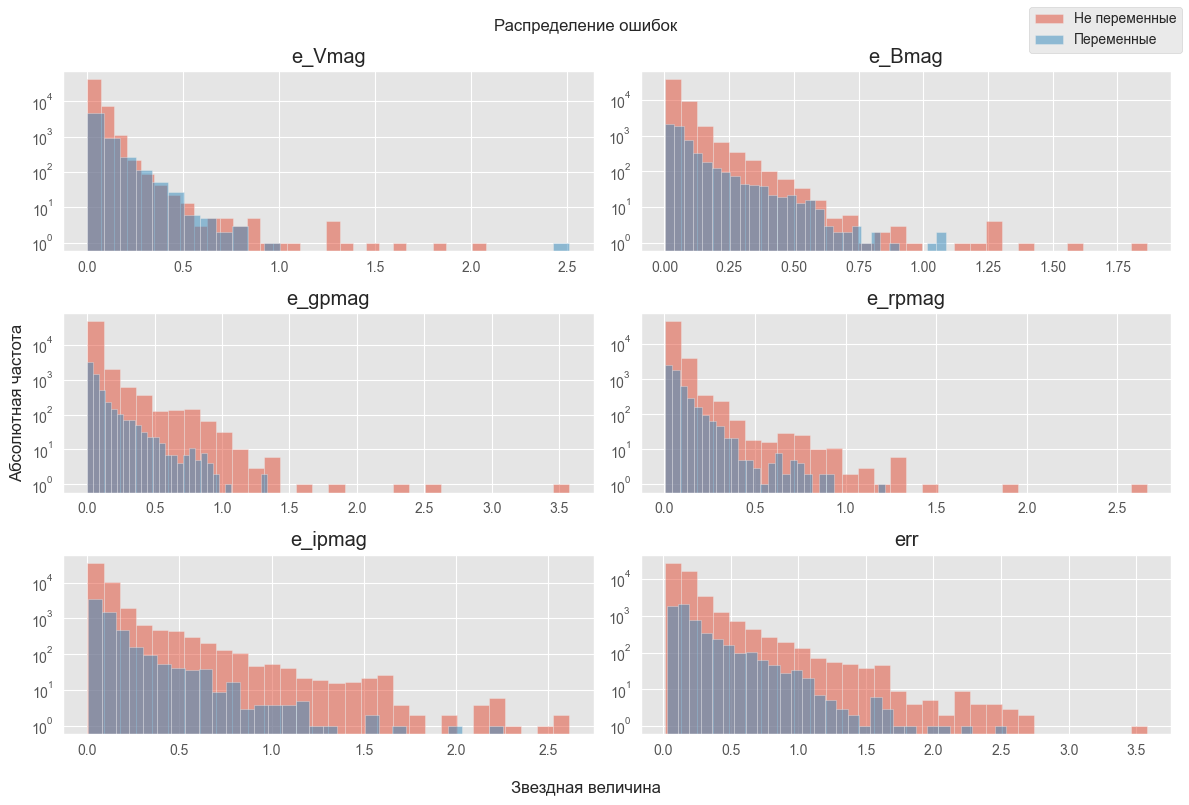

In [157]:
df_stage_1 = df.copy()

axes: np.ndarray[np.ndarray[plt.Axes]]
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for i, column in enumerate(["e_Vmag", "e_Bmag", "e_gpmag", "e_rpmag", "e_ipmag", "err"]):
    df_stage_1.loc[df["present"] == 0, column].plot(
        kind="hist", logy=True, ax=axes[i // 2, i % 2], alpha=.5, bins=30
    )
    df_stage_1.loc[df["present"] == 1, column].plot(
        kind="hist", logy=True, ax=axes[i // 2, i % 2], alpha=.5, bins=30
    )
    axes[i // 2, i % 2].set_ylabel("")
    axes[i // 2, i % 2].set_title(column)

fig.supxlabel("Звездная величина")
fig.supylabel("Абсолютная частота")
fig.suptitle("Распределение ошибок")
fig.legend(["Не переменные", "Переменные"])
fig.tight_layout()

Как видно из гистограмм, ошибка фотометрии наиболее "шумно" проявляется в полосе B, а наибольший хвост наблюдается в полосе G ($\approx80\%$ от основных значений).
Для переменных звезд подобных хвостов не наблюдается.

## **2 Цена тусклости**

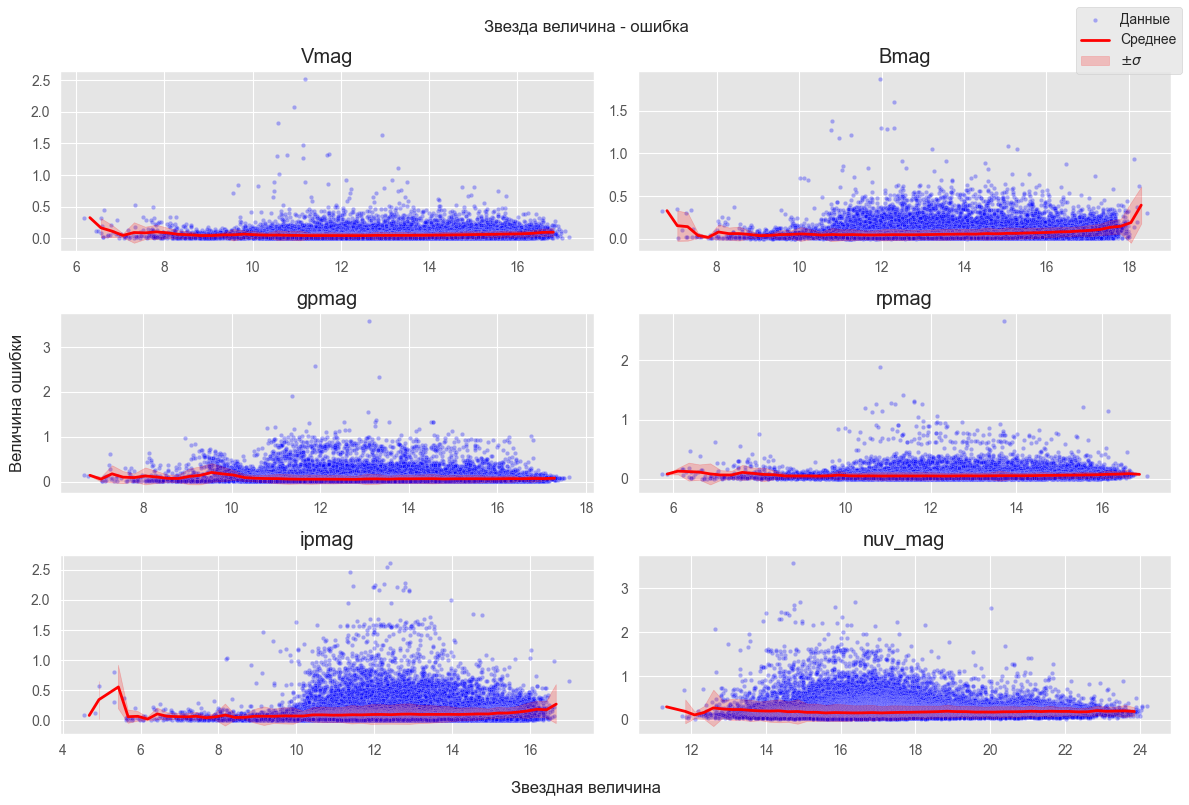

In [158]:
df_stage_2 = df.copy()
df_stage_2.rename(columns={"err": "e_nuv_mag"}, inplace=True)
df_stage_2["e_fuv_mag"] = df_stage_2["e_nuv_mag"]

axes: np.ndarray[np.ndarray[plt.Axes]]
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for i, column in enumerate(
        ["Vmag", "Bmag", "gpmag", "rpmag", "ipmag", "nuv_mag"]):
    ax = axes[i // 2, i % 2]

    mag = df_stage_2[column]
    err = df_stage_2[f'e_{column}']

    data = pd.DataFrame({'mag': mag, 'e_mag': err})

    bins = np.arange(mag.min(), mag.max(), 0.25)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    mean_err = [
        err[mag.between(bins[i], bins[i + 1])].mean() for i in range(len(bins) - 1)]
    std_err = [err[mag.between(bins[i], bins[i + 1])].std() for i in range(len(bins) - 1)]

    sns.scatterplot(x='mag', y='e_mag', data=data, s=10, alpha=0.3, color='blue', ax=ax)

    sns.lineplot(x=bin_centers, y=mean_err, color='red', ax=ax, linewidth=2)

    ax.fill_between(bin_centers,
                    np.array(mean_err) - np.array(std_err),
                    np.array(mean_err) + np.array(std_err),
                    color='red', alpha=0.2)

    ax.set_title(column)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True)

fig.supxlabel("Звездная величина")
fig.supylabel("Величина ошибки")
fig.suptitle("Звезда величина - ошибка")
fig.legend(["Данные", "Среднее", "$\\pm\\sigma$"])
plt.tight_layout()

Как видно из графиков, зависимость **не является** плавной, поскольку есть достаточно много выбросов (особенно заметно в полосе ipmag).

На графике показан возможный предел детектирования ($\overline{X}\pm\sigma$), поскольку это достаточно отражает возможные границы, остальные ошибки слишком высоки или низки, чтобы быть правдой (т.е. скорее всего это ошибки, возникшие в следствие механических факторов: повреждений, погоды и т.д.)

## **3 Сердце звёздного населения**

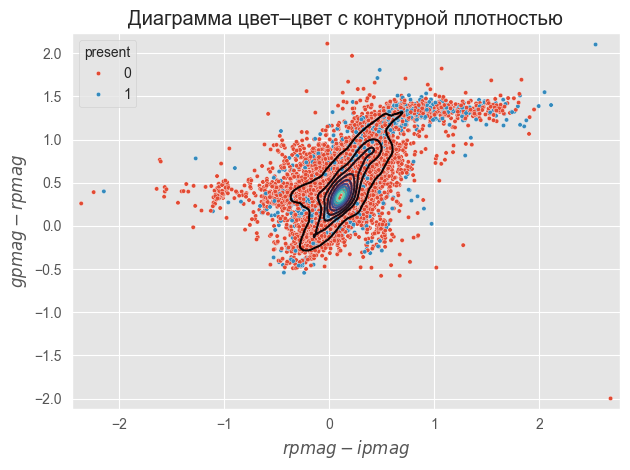

In [159]:
df_stage_3 = df.copy()
df_stage_3["g-r"] = df_stage_3["gpmag"] - df_stage_3["rpmag"]
df_stage_3["r-i"] = df_stage_3["rpmag"] - df_stage_3["ipmag"]

sns.scatterplot(
    x='r-i', y='g-r', data=df_stage_3, hue="present", s=10)
sns.kdeplot(x='r-i', y='g-r', data=df_stage_3, cmap="mako", linewidths=1.5, levels=10)
plt.xlabel("$rpmag - ipmag$")
plt.ylabel("$gpmag - rpmag$")
plt.title("Диаграмма цвет–цвет с контурной плотностью")
plt.tight_layout()

Как видно из графика, "сердце" данного распределения $\approx(0.1,\;0.4)$ - в этой части самое большое скопление звезд. Есть также две "ветви", одна уходить в правую сторону от основной части, другая - в левую.

Объекты, находящиеся дальше всех от основной группировки, могут быть либо красными звездами (сильно излучают в обоих цветах), либо голубыми объектами: например, белые карлики, квазары (очень слабо излучают в обоих рассматриваемых цветах), наконец, переменные звезды, поскольку для них смещение цвета не описывается так же, как для всей последовательности, поскольку она излучает не статично.

## **4 В поисках ультрафиолетовых изгоев**

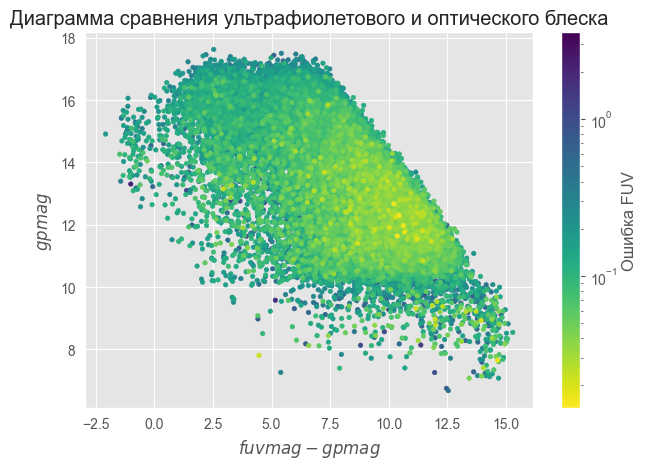

In [160]:
from matplotlib.colors import LogNorm

df_stage_4 = df.copy()
df_stage_4["fuv_mag-gpmag"] = df_stage_4["fuv_mag"] - df["gpmag"]

plt.scatter(
    x=df_stage_4["fuv_mag-gpmag"],
    y=df_stage_4["gpmag"],
    c=df_stage_4["err"],
    cmap=plt.get_cmap('viridis_r'),
    norm=LogNorm(vmin=df_stage_4['err'].min(), vmax=df_stage_4['err'].max()),
    s=10,
)

plt.xlabel("$fuv mag - gpmag$")
plt.ylabel("$gpmag$")
plt.colorbar(label="Ошибка FUV")
plt.title("Диаграмма сравнения ультрафиолетового и оптического блеска")
plt.tight_layout()

Можно заметить интересное наблюдение: если разделить визуально график на $gpamg>10$ и $gpmag\le10$, то можно заметить, что значения ниже указанного более разрежены, так же важно учесть, что именно в этой области находятся UV-яркие элементы ($fuvmag - gpmag$ принимает большие значения), поэтому можно сказать, что они образуют свою, обособленную группу.

Чем точнее измерение (на графике соответствует желтому оттенку), тем оно находится ближе к "центру" всех значений, т.е. значения группируются таким образом, что менее точные попадают на окраину, замыкая тем самым самые точные значения.

## **5 Следы качества на спектрах**

Text(0.5, 1.0, 'Медианное спектрально-энергетическое распределение СЭД')

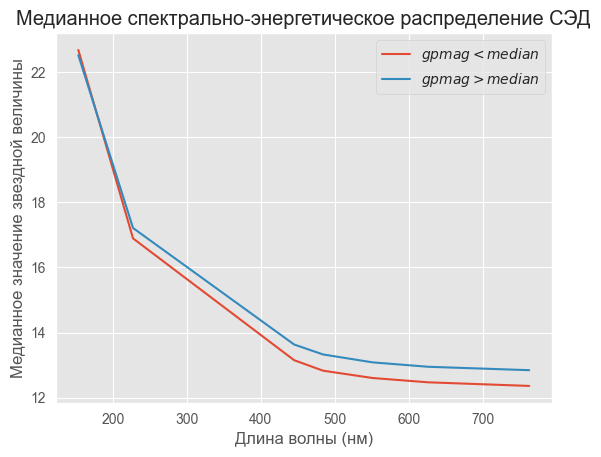

In [161]:
df_stage_5 = df.copy()
df_stage_5["quality"] = (
        df_stage_5["e_gpmag"] > df_stage_5["e_gpmag"].median()
).astype(int)

mag_length = {
    "Vmag": 551,
    "Bmag": 445,
    "gpmag": 484,
    "rpmag": 626,
    "ipmag": 763,
    "nuv_mag": 227,
    "fuv_mag": 153
}

sns.lineplot(
    x=list(mag_length.values()),
    y=[df_stage_5.loc[df_stage_5["quality"] == 0, mag].median()
       for mag in mag_length.keys()],
    label="$gpmag<median$"
)
sns.lineplot(
    x=list(mag_length.values()),
    y=[df_stage_5.loc[df_stage_5["quality"] == 1, mag].median()
       for mag in mag_length.keys()],
    label="$gpmag>median$"
)
plt.xlabel("Длина волны (нм)")
plt.ylabel("Медианное значение звездной величины")
plt.title("Медианное спектрально-энергетическое распределение СЭД")

Из графика видно, что качество данных gpmag все-таки влияет на итоговый результат: отклонения в основном заметны, начиная с длин волн $>400$ нм, что приблизительно и есть эфефективная длина волны $gpmag$.

Да, наблюдается систематическое завышение, начиная с длины волны $>210$ нм.

## **6 Ошибки измерения в пространстве цветов**

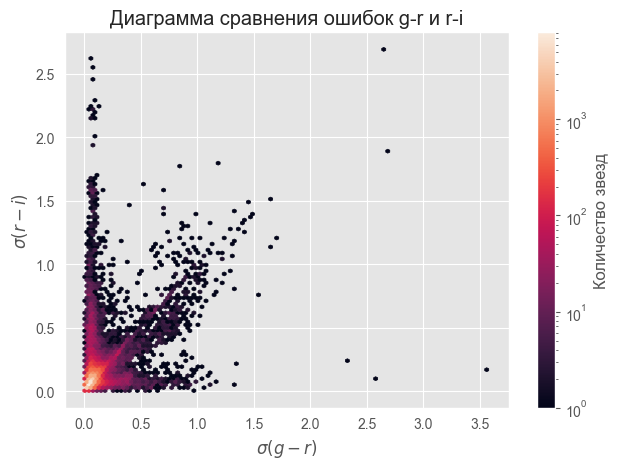

In [162]:
df_stage_6 = df.copy()
df_stage_6["sigma_g-r"] = np.sqrt(df["e_gpmag"] ** 2 + df["e_rpmag"] ** 2)
df_stage_6["sigma_r-i"] = np.sqrt(df["e_rpmag"] ** 2 + df["e_ipmag"] ** 2)

plt.hexbin(
    df_stage_6['sigma_g-r'], df_stage_6['sigma_r-i'], bins="log"
)
plt.colorbar(label='Количество звезд')
plt.xlabel("$\\sigma(g-r)$")
plt.ylabel("$\\sigma(r-i)$")
plt.title("Диаграмма сравнения ошибок g-r и r-i")
plt.tight_layout()

Наиболее велики ошибки в правой верхней части (можно сказать, выбросы), а также по вертикали с абсциссой $\approx0$, что соответствует ожиданиям, поскольку $gpmag$ и $rpmag$ распределены равномерно, а $ipmag$ имеет резкий скачок для малых звездных величин.

Да, ошибки действительно мешают выделению популяций, поскольку из-за них график сильно масштабируется, что затрудняет детальное изучение левого нижнего угла, где и сосредоточено большинство значений.